In [185]:
import os
from pathlib import Path
import json

import numpy as np
import cv2 as cv
from skimage.io import imread

import matplotlib.pyplot as plt

np.random.seed(42)

In [186]:
def load_train_data(input_dir, newSize=(64,64)):    
    image_dir = Path(input_dir)
    categories_name = []
    for file in os.listdir(image_dir):
        d = os.path.join(image_dir, file)
        if os.path.isdir(d):
            categories_name.append(file)

    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]

    train_img = []
    categories_count=[]
    labels=[]
    for i, direc in enumerate(folders):
        count = 0
        for obj in direc.iterdir():
            if os.path.isfile(obj) and os.path.basename(os.path.normpath(obj)) != 'desktop.ini':
                labels.append(os.path.basename(os.path.normpath(direc)))
                count += 1
                img = imread(obj)#zwraca ndarry postaci xSize x ySize x colorDepth
                img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)# zwraca ndarray
                # img = img / 255#normalizacja
                train_img.append(img)
        categories_count.append(count)
    X={}
    X["values"] = np.array(train_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X

def load_test_data(input_dir, newSize=(64,64)):
    image_path = Path(input_dir)
    labels_path = image_path.parents[0] / 'test_labels.json'
    jsonString = labels_path.read_text()
    objects = json.loads(jsonString)
    categories_name = []
    categories_count=[]
    count = 0
    c = objects[0]['value']
    for e in  objects:
        if e['value'] != c:
            categories_count.append(count)
            c = e['value']
            count = 1
        else:
            count += 1
        if not e['value'] in categories_name:
            categories_name.append(e['value'])

    categories_count.append(count)
    test_img = []
    labels=[]
    for e in objects:
        p = image_path / e['filename']
        img = imread(p)
        img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)
        # img = img / 255
        test_img.append(img)
        labels.append(e['value'])


    X={}
    X["values"] = np.array(test_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X

In [187]:
class Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

In [188]:
class ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

In [189]:
class Sigmoid:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))

    def backward(self, dvalues):
        self.dinputs = dvalues * (1 - self.output) * self.output

In [190]:
class Softmax:
    def forward(self, inputs):
        self.inputs = inputs

        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)
        self.output = probabilities

    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)

        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1, 1)
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix,
                                         single_dvalues)

In [191]:
class SGD:
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        if self.momentum:
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)

            weight_updates = \
                self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            bias_updates = \
                self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        else:
            weight_updates = -self.current_learning_rate * \
                             layer.dweights
            bias_updates = -self.current_learning_rate * \
                           layer.dbiases

        layer.weights += weight_updates
        layer.biases += bias_updates

    def post_update_params(self):
        self.iterations += 1

In [192]:
class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

In [193]:
class CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]

        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])

        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples

In [194]:
class Model:
    def __init__(self, layers):
        self.layers = layers

    def _forward(self, X):
        for layer in self.layers:
            layer.forward(X)
            X = layer.output
        return X

    def _backward(self, dinputs, optimizer):
        for layer in reversed(self.layers):
            layer.backward(dinputs)
            dinputs = layer.dinputs
        optimizer.pre_update_params()
        for layer in self.layers:
            if hasattr(layer, 'weights'):
                optimizer.update_params(layer)
        optimizer.post_update_params()

    @staticmethod
    def get_batches(X, y, batch_size):
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        for start_idx in range(0, len(X) - batch_size + 1, batch_size):
            excerpt = indices[start_idx:start_idx + batch_size]
            yield X[excerpt], y[excerpt]


    def fit(self, X_data, y_data, X_val_data, y_val_data,
            epochs, loss_function, optimizer, batch_size=128):
        ls = []
        acc = []
        for epoch in range(epochs):
            loss_acum = []
            for X_batch, y_batch in self.get_batches(X_data, y_data, batch_size):
                output = self._forward(X_batch)
                loss = loss_function.calculate(output, y_batch)
                loss_function.backward(output, y_batch)
                self._backward(loss_function.dinputs, optimizer)
                loss_acum.append(loss)
            ls.append([epoch, np.mean(loss_acum)])

            if not epoch % 100:
                output = self._forward(X_val_data)
                predictions = np.argmax(output, axis=1)
                y = y_val_data.copy()
                if len(y.shape) == 2:
                       y = np.argmax(y, axis=1).copy()
                accuracy = np.mean(predictions == y)
                print(f'epoch: {epoch}, ' +
                      f'acc: {accuracy:.3f}')
                acc.append([epoch, accuracy])
        return ls, acc

    def predict(self, X):
        return np.argmax(self._forward(X), axis=1)

In [195]:
train_data = load_test_data('./train_test_sw/test_sw')
label_to_num = {name: i for i, name in enumerate(train_data['categories_name'])}
one_hot_label = []
for label in train_data['labels']:
    tmp = np.zeros((1, len(label_to_num)))
    tmp[0, label_to_num[label]] = 1
    one_hot_label.append(tmp)

y = np.array(one_hot_label).reshape(-1, len(label_to_num))
X = (train_data['values'].reshape(-1, 64*64*4) - 127.5) / 127.5
num_examples = X.shape[0]
indices = np.arange(num_examples)
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

test_data = load_test_data('./train_test_sw/test_sw')
X_val = (test_data['values'].reshape(-1, 64*64*4) - 127.5) / 127.5
one_hot_label = []
for label in test_data['labels']:
    tmp = np.zeros((1, len(label_to_num)))
    tmp[0, label_to_num[label]] = 1
    one_hot_label.append(tmp)

y_val = np.array(one_hot_label).reshape(-1, len(label_to_num))
num_examples = X_val.shape[0]
indices = np.arange(num_examples)
np.random.shuffle(indices)
X_val = X_val[indices]
y_val = y_val[indices]

In [196]:
model_relu = Model([
    Dense(64*64*4, 128),
    ReLU(),
    Dense(128, 5),
    Softmax()
])

oprimizer = SGD(learning_rate=1e-3, momentum=0.9)
loss_function = CategoricalCrossentropy()

relu_loss_acc = model_relu.fit(X, y, X_val, y_val, 500, loss_function, oprimizer)

epoch: 0, acc: 0.208
epoch: 100, acc: 0.490
epoch: 200, acc: 0.703
epoch: 300, acc: 0.830
epoch: 400, acc: 0.907


In [197]:
model_sigmoid = Model([
    Dense(64*64*4, 128),
    Sigmoid(),
    Dense(128, 5),
    Softmax()
])

oprimizer = SGD(learning_rate=5e-3, momentum=0.9)
sigmoid_loss_acc = model_sigmoid.fit(X, y, X_val, y_val, 500, loss_function, oprimizer)

epoch: 0, acc: 0.174
epoch: 100, acc: 0.432
epoch: 200, acc: 0.633
epoch: 300, acc: 0.846
epoch: 400, acc: 0.861


In [198]:
sigmoid_loss = np.array(sigmoid_loss_acc[0])
sigmoid_acc = np.array(sigmoid_loss_acc[1])
relu_loss = np.array(relu_loss_acc[0])
relu_acc = np.array(relu_loss_acc[1])

In [199]:
relu_loss

array([[0.00000000e+00, 1.61316018e+00],
       [1.00000000e+00, 1.61210100e+00],
       [2.00000000e+00, 1.60932988e+00],
       [3.00000000e+00, 1.60829510e+00],
       [4.00000000e+00, 1.60635571e+00],
       [5.00000000e+00, 1.60654747e+00],
       [6.00000000e+00, 1.60373875e+00],
       [7.00000000e+00, 1.60285231e+00],
       [8.00000000e+00, 1.60264695e+00],
       [9.00000000e+00, 1.60131950e+00],
       [1.00000000e+01, 1.60021548e+00],
       [1.10000000e+01, 1.59936920e+00],
       [1.20000000e+01, 1.59724461e+00],
       [1.30000000e+01, 1.59579902e+00],
       [1.40000000e+01, 1.59549449e+00],
       [1.50000000e+01, 1.59429267e+00],
       [1.60000000e+01, 1.59237753e+00],
       [1.70000000e+01, 1.59169315e+00],
       [1.80000000e+01, 1.59054058e+00],
       [1.90000000e+01, 1.58941497e+00],
       [2.00000000e+01, 1.58874714e+00],
       [2.10000000e+01, 1.58665577e+00],
       [2.20000000e+01, 1.58500476e+00],
       [2.30000000e+01, 1.58372999e+00],
       [2.400000

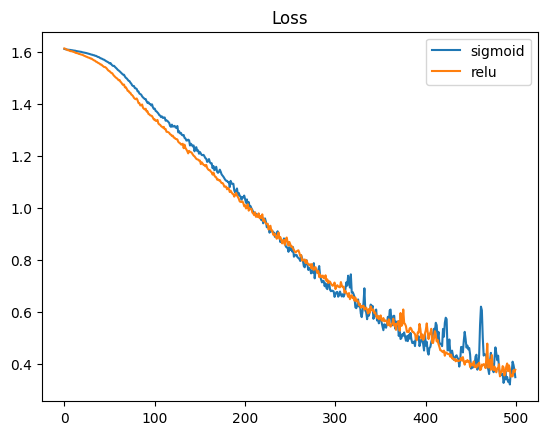

In [200]:
plt.plot(sigmoid_loss[:, 0], sigmoid_loss[:, 1], label='sigmoid')
plt.plot(relu_loss[:, 0], relu_loss[:, 1], label='relu')
plt.legend()
plt.title('Loss')
plt.show()

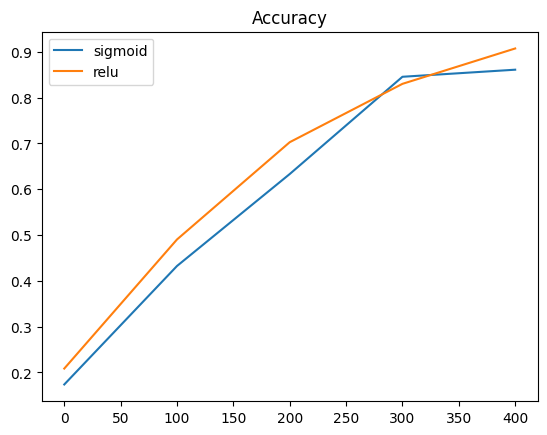

In [201]:
plt.plot(sigmoid_acc[:, 0], sigmoid_acc[:, 1], label='sigmoid')
plt.plot(relu_acc[:, 0], relu_acc[:, 1], label='relu')
plt.legend()
plt.title('Accuracy')
plt.show()

In [202]:
relu_loss_acc

([[0, 1.6131601822960753],
  [1, 1.6121010017894826],
  [2, 1.6093298766464075],
  [3, 1.6082950966744751],
  [4, 1.6063557059154343],
  [5, 1.60654746969187],
  [6, 1.6037387547149722],
  [7, 1.6028523148307592],
  [8, 1.6026469532734766],
  [9, 1.601319496014742],
  [10, 1.6002154758481537],
  [11, 1.5993691955897313],
  [12, 1.597244607077478],
  [13, 1.5957990197593828],
  [14, 1.595494488509706],
  [15, 1.5942926680886975],
  [16, 1.5923775349796927],
  [17, 1.5916931538945156],
  [18, 1.5905405808958235],
  [19, 1.5894149734492484],
  [20, 1.5887471368735286],
  [21, 1.5866557690662342],
  [22, 1.5850047594337995],
  [23, 1.5837299873980952],
  [24, 1.581867048103949],
  [25, 1.5806708766890099],
  [26, 1.5789445439803416],
  [27, 1.5780109050493734],
  [28, 1.57668878718231],
  [29, 1.5742267120618232],
  [30, 1.574509744508606],
  [31, 1.5715509006981947],
  [32, 1.5694493930768396],
  [33, 1.5671395656763787],
  [34, 1.5658648327125544],
  [35, 1.5624603837192597],
  [36, 1.56